# L2 FWI Example
We will solve this problem using the following steps:
1. Read the true and starting models from binary files coarsen them and visualize
2. Build up a small local compute cluster and load packages onto the compute cluster
3. Build F, the forward modeling operator
4. Use F and the true model to create a synthetic data-set
5. Build the gradient and cost functions
6. Do the FWI using optim.jl

In [6]:
using PyPlot, Distributed

### 1. Read the true and starting models from binary files coarsen them and visualize

In [7]:
v = read!("../02_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));
vₒ= read!("../02_marmousi_model_setup/marmousi_vp_smooth_20m_176x851.bin", Array{Float32}(undef, 176,851));

In [8]:
v = v[1:2:end,1:2:end]
vₒ = vₒ[1:2:end,1:2:end];

In [9]:
dz,dx = 40.0,40.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (40.0, 40.0)
(nz, nx) = (88, 426)


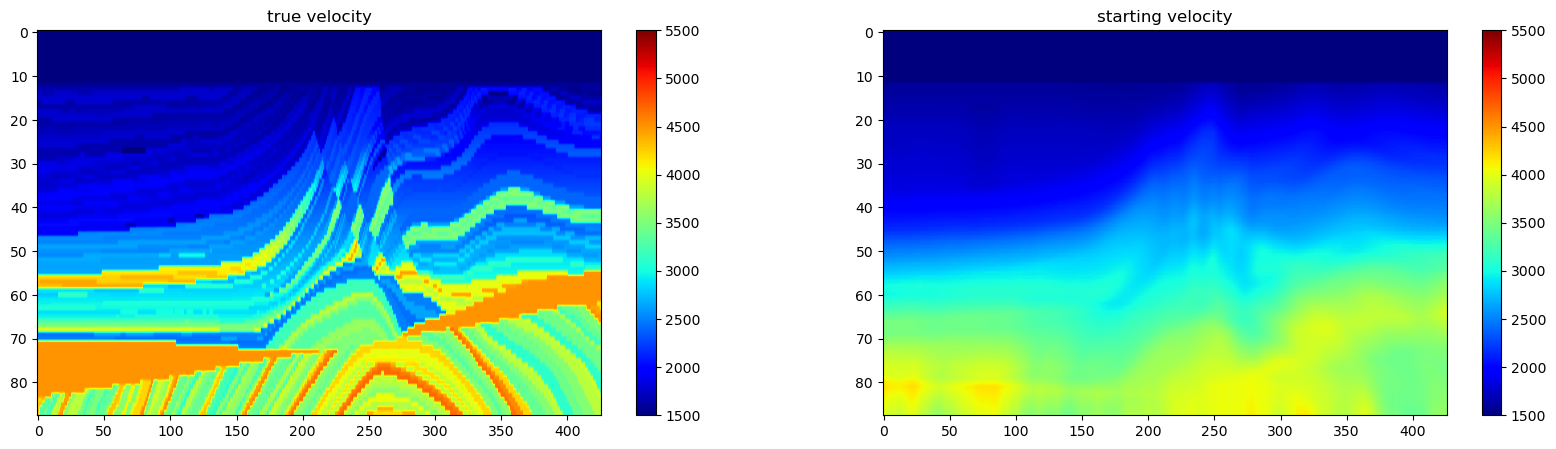

In [10]:
figure(figsize=(20,5))
subplot(121);imshow(v,aspect="auto",cmap="jet");colorbar();clim(1500,5500);title("true velocity")
subplot(122);imshow(vₒ,aspect="auto",cmap="jet");colorbar();clim(1500,5500);title("starting velocity");

### 2. Build up a small local compute cluster and load packages onto the compute cluster

In [11]:
addprocs(4);

In [12]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, JetPackWave, LinearAlgebra, LineSearches, Optim, Wave, Random

┌ Info: Precompiling JetPack [24ef3835-3876-54c3-8a7a-956cf69ca0b2]
└ @ Base loading.jl:1278
┌ Info: Precompiling JetPackWave [a870704c-6179-11e9-3c8a-092b3cdd473b]
└ @ Base loading.jl:1278


### 3. Build F, the forward modeling operator

8 shot locations (only using 8 because we are using our local machines to run the FWI)

In [13]:
sx = (0.0:dx*60:(nx-1)*dx)
nshots = length(sx)
@show nshots;

nshots = 8


In [14]:
@everywhere function makeF(i,scratchdir,peakfreq,sx,nz,nx,dz,dx)
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        comptype = UInt32,
        ntrec = 1101,
        dtrec = 0.004,
        dtmod = 0.001,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=peakfreq),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(nx),
        srcfieldfile = "$scratchdir/field-$(i)-$(randstring()).bin",
        reportinterval=0,
        nthreads=Sys.CPU_THREADS/4)
end

In [15]:
F = @blockop DArray(I->[makeF(i,"/scratch",1.0,sx,nz,nx,dz,dx) for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (88, 426) → (3752208,)"

### 4. Use F and the true model to create a synthetic data-set

In [16]:
# This may take awhile if running on a single node

@time begin
    d = F*v;
end

LoadError: TaskFailedException:
On worker 2:
MethodError: no method matching injectdata!(::Array{Float32,2}, ::Array{Float32,2}, ::Int64, ::Wave.InjectionBlocking{Float32,2}, ::Float64)
Closest candidates are:
  injectdata!(::AbstractArray{Float32,2}, ::AbstractArray{Float32,2}, ::Integer, ::Wave.InjectionBlocking{Float32,2}, !Matched::Integer) at /home/cvx/.julia/packages/Wave/lOu8c/src/spacetime.jl:998
  injectdata!(::Array{T,2}, ::Array{T,2}, ::Integer, !Matched::Array{Int64,1}, !Matched::Array{Int64,1}, !Matched::Array{T,1}) where T at /home/cvx/.julia/packages/Wave/lOu8c/src/spacetime.jl:1249
  injectdata!(::Array{T,2}, ::Array{T,2}, ::Integer, !Matched::Array{Int64,1}, !Matched::Array{Int64,1}, !Matched::Array{T,1}, !Matched::Wave.Language) where T at /home/cvx/.julia/packages/Wave/lOu8c/src/spacetime.jl:1249
  ...
macro expansion at /home/cvx/.julia/packages/JetPackWave/zwtzD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:221 [inlined]
macro expansion at ./timing.jl:233 [inlined]
#JopProp2DAcoIsoDenQ_DEO2_FDTD_nonlinearforward!#97 at /home/cvx/.julia/packages/JetPackWave/zwtzD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:220
#JopProp2DAcoIsoDenQ_DEO2_FDTD_f!#98 at /home/cvx/.julia/packages/JetPackWave/zwtzD/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:261
#f!#8 at /home/cvx/.julia/packages/Jets/X0rrg/src/Jets.jl:79 [inlined]
mul! at /home/cvx/.julia/packages/Jets/X0rrg/src/Jets.jl:168 [inlined]
#JetBlock_f!#82 at /home/cvx/.julia/packages/Jets/X0rrg/src/Jets.jl:610
#f!#8 at /home/cvx/.julia/packages/Jets/X0rrg/src/Jets.jl:79
mul! at /home/cvx/.julia/packages/Jets/X0rrg/src/Jets.jl:168 [inlined]
JetDBlock_local_f! at /home/cvx/.julia/packages/DistributedJets/XIUAg/src/DistributedJets.jl:454
#106 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:294
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:79
macro expansion at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:294 [inlined]
#105 at ./task.jl:356
Stacktrace:
 [1] remotecall_fetch(::Function, ::Distributed.Worker, ::DBArray{Float32,Jets.BlockArray{Float32,Array{Float32,2}},Array{Jets.BlockArray{Float32,Array{Float32,2}},1}}, ::Vararg{Any,N} where N; kwargs::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/remotecall.jl:394
 [2] remotecall_fetch(::Function, ::Distributed.Worker, ::DBArray{Float32,Jets.BlockArray{Float32,Array{Float32,2}},Array{Jets.BlockArray{Float32,Array{Float32,2}},1}}, ::Vararg{Any,N} where N) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/remotecall.jl:386
 [3] remotecall_fetch(::Function, ::Int64, ::DBArray{Float32,Jets.BlockArray{Float32,Array{Float32,2}},Array{Jets.BlockArray{Float32,Array{Float32,2}},1}}, ::Vararg{Any,N} where N; kwargs::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/remotecall.jl:421
 [4] remotecall_fetch at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/remotecall.jl:421 [inlined]
 [5] (::DistributedJets.var"#76#77"{DBArray{Float32,Jets.BlockArray{Float32,Array{Float32,2}},Array{Jets.BlockArray{Float32,Array{Float32,2}},1}},DArray{JopNl{Jet{JetSpace{Float32,2},JetBSpace{Float32,JetSpace{Float32,2}},typeof(Jets.JetBlock_f!),typeof(Jets.JetBlock_df!),typeof(Jets.JetBlock_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:ops, :dom, :rng),Tuple{Array{JopNl{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPackWave.JopProp2DAcoIsoDenQ_DEO2_FDTD_f!),typeof(JetPackWave.JopProp2DAcoIsoDenQ_DEO2_FDTD_df!),typeof(JetPackWave.JopProp2DAcoIsoDenQ_DEO2_FDTD_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:b, :srcfieldfile, :srcfieldhost, :chksum, :compressor, :isinterior, :sz, :sx, :st, :interpmethod, :rz, :rx, :z0, :x0, :dz, :dx, :freqQ, :qMin, :qInterior, :nsponge, :ginsu, :dtmod, :dtrec, :ntrec, :nbz_cache, :nbx_cache, :nbz_inject, :nbx_inject, :wavelet, :freesurface, :nthreads, :reportinterval, :stats),Tuple{Array{Float32,2},String,Base.RefValue{String},Base.RefValue{UInt32},Dict{String,Wave.Compressor{Float32,Float32,UInt32,2}},Bool,Array{Float64,1},Array{Float64,1},Array{Float64,1},Symbol,Array{Float64,1},Array{Float64,1},Float64,Float64,Float32,Float32,Float32,Float32,Float32,Int64,Ginsu{2,JopLn{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:pad, :extend, :accumulate),Tuple{Tuple{UnitRange{Int64},UnitRange{Int64}},Bool,Bool}}}},JopLn{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:pad, :extend, :accumulate),Tuple{Tuple{UnitRange{Int64},UnitRange{Int64}},Bool,Bool}}}},JopLn{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:pad, :extend, :accumulate),Tuple{Tuple{UnitRange{Int64},UnitRange{Int64}},Bool,Bool}}}},JopLn{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:pad, :extend, :accumulate),Tuple{Tuple{UnitRange{Int64},UnitRange{Int64}},Bool,Bool}}}}},Float32,Float32,Int64,Int64,Int64,Int64,Int64,WaveletCausalRicker,Bool,Float64,Int64,Dict{String,Float64}}}}},2},JetSpace{Float32,2},JetBSpace{Float32,JetSpace{Float32,2}}}}}},2,Array{JopNl{Jet{JetSpace{Float32,2},JetBSpace{Float32,JetSpace{Float32,2}},typeof(Jets.JetBlock_f!),typeof(Jets.JetBlock_df!),typeof(Jets.JetBlock_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:ops, :dom, :rng),Tuple{Array{JopNl{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPackWave.JopProp2DAcoIsoDenQ_DEO2_FDTD_f!),typeof(JetPackWave.JopProp2DAcoIsoDenQ_DEO2_FDTD_df!),typeof(JetPackWave.JopProp2DAcoIsoDenQ_DEO2_FDTD_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:b, :srcfieldfile, :srcfieldhost, :chksum, :compressor, :isinterior, :sz, :sx, :st, :interpmethod, :rz, :rx, :z0, :x0, :dz, :dx, :freqQ, :qMin, :qInterior, :nsponge, :ginsu, :dtmod, :dtrec, :ntrec, :nbz_cache, :nbx_cache, :nbz_inject, :nbx_inject, :wavelet, :freesurface, :nthreads, :reportinterval, :stats),Tuple{Array{Float32,2},String,Base.RefValue{String},Base.RefValue{UInt32},Dict{String,Wave.Compressor{Float32,Float32,UInt32,2}},Bool,Array{Float64,1},Array{Float64,1},Array{Float64,1},Symbol,Array{Float64,1},Array{Float64,1},Float64,Float64,Float32,Float32,Float32,Float32,Float32,Int64,Ginsu{2,JopLn{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:pad, :extend, :accumulate),Tuple{Tuple{UnitRange{Int64},UnitRange{Int64}},Bool,Bool}}}},JopLn{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:pad, :extend, :accumulate),Tuple{Tuple{UnitRange{Int64},UnitRange{Int64}},Bool,Bool}}}},JopLn{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:pad, :extend, :accumulate),Tuple{Tuple{UnitRange{Int64},UnitRange{Int64}},Bool,Bool}}}},JopLn{Jet{JetSpace{Float32,2},JetSpace{Float32,2},typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df!),typeof(JetPack.JopPad_df′!),Jets.var"#4#7",Array{Float32,2},NamedTuple{(:pad, :extend, :accumulate),Tuple{Tuple{UnitRange{Int64},UnitRange{Int64}},Bool,Bool}}}}},Float32,Float32,Int64,Int64,Int64,Int64,Int64,WaveletCausalRicker,Bool,Float64,Int64,Dict{String,Float64}}}}},2},JetSpace{Float32,2},JetBSpace{Float32,JetSpace{Float32,2}}}}}},2}},DistributedOperations.TypeFutures{Array{Float32,2}},Int64})() at ./task.jl:356

...and 3 more exception(s).


Plot a subset of shot gathers from the in-memory distributed array

In [ ]:
ishots = [1, 2, 4, 6, 8]
figure(figsize=(14,5))
for (iplot,ishot) in enumerate(ishots)
    subplot(1,5,iplot);imshow(getblock(d,ishot)[:,:,1],cmap="gray",aspect="auto",clim=[-10,10]);title("shot $(ishot)");
end
tight_layout()

### 5. Build the gradient and cost functions

In [ ]:
function gradient!(G,F,v,dobs,p)
    J = jacobian(F,v)
    s = srcillum(J)
    s .= (s ./ maximum(s)) .+ 1e-8
    R = JopDiagonal((1 ./ s).^2)
    G .= R' ∘ J' * (dobs - F*v)
    if p.gscale == 0.0
       p.gscale = 10 ./ maximum(G)
    end
    G .*= p.gscale
    
    close(F) #delete local files
end
mutable struct FwiPar
   gscale
end
p = FwiPar(0.0)
g!(G,x) = gradient!(G,F,x,d,p)

In [ ]:
grad = zeros(Float32,size(v))
g!(grad,vₒ)

In [ ]:
figure(figsize=(10,5))
imshow(grad,aspect="auto",cmap="seismic");colorbar();clim(-10,10);title("gradient");

In [ ]:
function cost(x,F,d)
    phi = norm(d .- F*x)
    return phi
    close(F) #delete local files
end
f(x) = cost(x,F,d)

In [ ]:
@info "initial cost $(f(vₒ))";

### 6. Do the FWI using optim.jl

In [ ]:
solver = LBFGS(m = 20, alphaguess = LineSearches.InitialQuadratic(), linesearch = LineSearches.MoreThuente());

In [ ]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

In [ ]:
redirect_stdout(open("/dev/null","w")) # otherwise the models are printed to stdout at every iteration
result = optimize(f, g!, vₒ, solver,
    Optim.Options(
        iterations = 100,
        show_trace = true,
        store_trace = true,
        show_every = 1,
        extended_trace = true,
        allow_f_increases = true,
        callback = mycallback))

In [ ]:
vfwi = Optim.minimizer(result) # optimal solution
ϕ = Optim.f_trace(result)   # cost vs iteration
m = Optim.x_trace(result)   # model vs iteration

In [ ]:
rmprocs(workers())

In [ ]:
figure(figsize=(20,5))
subplot(121);imshow(v,aspect="auto",cmap="jet");colorbar();clim(1.5,5.5);title("true velocity")
subplot(122);imshow(vfwi,aspect="auto",cmap="jet");colorbar();clim(1.5,5.5);title("fwi velocity");